# TFM - SHAP 

Using the Shap and a CNN previously developped for Deep Learning:

+ Developing a CNN model to classify X-ray images with high accuracy.
+ To explore classifier explanation methods.

In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Multiply, Dot, Concatenate, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [3]:
def format_set(X_train, X_cv, X_test, img_width = 224, img_height = 224,grayscale = False):
    from tensorflow.keras import backend as K

    if K.image_data_format() == 'channels_first':
        if grayscale == False:      
#             input_shape = (3, img_width, img_height)
            X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
        else:
            X_train=X_train.reshape(X_train.shape[0],1,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],1,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],1,img_width,img_height)
    else:
        if grayscale == False:      
    #         input_shape = (img_width, img_height, 3)
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)
        else:
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,1)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,1)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,1)

    return X_train, X_cv, X_test

In [4]:
def grey(Im):
    '''Get greyscale images'''
    return np.dot(Im, [0.2989, 0.5870, 0.1140]) #By definition of Pillow

In [5]:
def image_load(directory, filename,sizeh = 224,sizev = 224,grayscale = False):
    '''Join directory and filename, load image, reshape to sizeh,sizev and normalize'''
    filename=os.path.join(directory, filename)
    if grayscale == False:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev)) #Full name to avoid variable interference
        im=np.reshape(im,(sizeh,sizev,3))
    else:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev),color_mode = 'grayscale')
        im=np.reshape(im,(sizeh,sizev))
    im=im.astype('float32') / 255
    return im

In [6]:
def super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False):
    '''For labels, pass data first and label second, as a list'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
            Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
                Label_crop = np.flipud(Label_crop)
            images.append(X_crop),labels.append(Label_crop)            
        else:
            X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
            images.append(X_crop)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [8]:
def generate_confusion_matrix(y_full_test,yhat_full_test):
    print(classification_report(y_full_test,yhat_full_test))
    C = confusion_matrix(y_full_test,yhat_full_test)
    
    # count of true negatives is [0,0], false negatives is [1,0], true positives is [1,1] and false positives is [0,1].
    TP, TN, FP, FN = C[1,1], C[0,0], C[0,1], C[1,0]
    var_name = [['TN','FP'],['FN','TP']]
    
    #Plot the confusion matrix
    
    plt.imshow(C,interpolation='nearest', cmap=plt.cm.tab20c)
    [[plt.text(i,j,var_name[i][j] +' :' + str(C[i,j]))] for i in [0,1] for j in [0,1]]
    plt.tick_params(axis='both',length=0,labelsize = 0)
    plt.axhline(0.5), plt.axvline(0.5)
    plt.show()
    
    print('accuracy is :',(TP + TN) / (TP + TN + FP + FN))
    print('F1 score is :',(2 * TP) / (2*TP + FP + FN))
    print('Miss rate is :',(FN) / (TP + FN))
    print('NPV is :',(TN) / (TN + FN))
    print('\n')
    print('Error rate :', (FP+FN)/(TP+TN+FP+FN))
    print('Sensitivity / Recall :', TP / (TP+FN))
    print('Specificity :',TN / (TN+FP))
    print('Precision :',TP / (TP+FP))
    print('False positive rate :',FP / (TN+FP))

In [9]:
def model_graphs(model,regression = False,labels = True):  
    loss_comb = model.history.history['loss']
    loss_val = model.history.history['val_loss']
    if regression == False:
        acc_comb = model.history.history['accuracy']
        acc_val = model.history.history['val_accuracy']
    else: 
        acc_comb = model.history.history['mae']
        acc_val = model.history.history['val_mae']
    epochs = np.array(model.history.epoch) + 1

    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(epochs,loss_comb)
    plt.plot(epochs,loss_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Binary crossentropy')
    else:
        plt.ylabel('Mean Squared Error')
    if labels == True:
        plt.title('Image & Label model results - Loss')
    else:
        plt.title('Image model results - Loss')
    plt.legend(['Training loss','Validation loss'])

    plt.subplot(122)
    plt.plot(epochs,acc_comb)
    plt.plot(epochs,acc_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Accuracy %')
        if labels == True:
            plt.title('Image & Label model results - Accuracy')
        else:
            plt.title('Image model results - Accuracy')
        plt.legend(['Training acc','Validation acc'])
    else:
        plt.ylabel('MAE')
        plt.title('Image & Label model results - MAE')
        plt.legend(['Training mae','Validation mae'])
    plt.show()

Download the data in a directory called `CCA2_png`.

### Dictionary with classes

In [11]:
df=pd.read_excel('imt_data.xlsx')
df.head()

,File_name,Label_file_name,ID,Side,Followup,Extension,IMT,Class,Exists?
0,050080144_LCCAg.png,_data_CCA2_050080144_LCCAg.png,50080,LCCAg,144,.png,0.617,0,True
1,050080144_RCCAg.png,_data_CCA2_050080144_RCCAg.png,50080,RCCAg,144,.png,0.947,0,True
2,050096156_LCCAg.png,_data_CCA2_050096156_LCCAg.png,50096,LCCAg,156,.png,0.770,0,True
3,050096156_RCCAg.png,_data_CCA2_050096156_RCCAg.png,50096,RCCAg,156,.png,0.715,0,True
4,050101156_LCCAg.png,_data_CCA2_050101156_LCCAg.png,50101,LCCAg,156,.png,0.851,0,True


In [12]:
kv_dict= dict(zip(df['File_name'].values,df['Class'].values))
dict(list(kv_dict.items())[:8])

{'050080144_LCCAg.png': 0,
 '050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050096156_RCCAg.png': 0,
 '050101156_LCCAg.png': 0,
 '050101156_RCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0}

In [30]:
#Data with labels
df_tag = df[df['Exists?']==True]
kv_tag_dict= dict(zip(df_tag['Label_file_name'].values,df_tag['Class'].values))
dict(list(kv_tag_dict.items())[:8])

{'_data_CCA2_050080144_LCCAg.png': 0,
 '_data_CCA2_050080144_RCCAg.png': 0,
 '_data_CCA2_050096156_LCCAg.png': 0,
 '_data_CCA2_050096156_RCCAg.png': 0,
 '_data_CCA2_050101156_LCCAg.png': 0,
 '_data_CCA2_050101156_RCCAg.png': 0,
 '_data_CCA2_050194156_LCCAg.png': 0,
 '_data_CCA2_050194156_RCCAg.png': 0}

In [31]:
#Dictionary used for regression
kv_dict_imt = dict(zip(df['File_name'].values,df['IMT'].values))
dict(list(kv_dict_imt.items())[:8])

{'050080144_LCCAg.png': 0.617,
 '050080144_RCCAg.png': 0.947,
 '050096156_LCCAg.png': 0.77,
 '050096156_RCCAg.png': 0.715,
 '050101156_LCCAg.png': 0.851,
 '050101156_RCCAg.png': 0.936,
 '050194156_LCCAg.png': 0.512,
 '050194156_RCCAg.png': 0.622}

### Data augmentation

In [20]:
224 - 19, 224 - 19 #We will reduce images to (205,205,3)

(205, 205)

#### Create images, or load the existing augmented images in the next section

In [43]:
#Create new images from images with plaque & modify the old ones to be smaller
Full_data = []
Full_label = []

directory_file = 'CCA2_png'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        #Apply transformation to orginal images
        d = super_cropper(im_data,generate = 1)[0]
        Full_data.append(d.astype('float32'))
        Full_label.append(kv_dict.get(filename))
        plt.imsave('./CCA2_png_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        counter+=1

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1} #Get a dictionary with only the images with plaque

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,generate = generate_nb)
            for image in d:
                Full_data.append(image.astype('float32'))
                Full_label.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./CCA2_png_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

In [11]:
#If all files are already created, load them here
Full_data = []
Full_label = []
directory='CCA2_png_augmented'

for filename in tqdm_notebook(os.listdir(directory)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label.append(np.int64(0))
        im = image_load(directory, filename, sizeh = 205, sizev = 205)
        Full_data.append(im)
    else:
        continue

In [12]:
print(len(Full_data))
print(sum(Full_label))
sum(Full_label) / len(Full_data) #Share of 

9551
4860


0.5088472411265836

In [13]:
#Train Test Split
X_full_train, X_full_1, y_full_train, y_full_1 = train_test_split(np.array(Full_data), np.array(Full_label), 
                                                              test_size=0.2, random_state=42, stratify = Full_label)
#Train Test Split
X_full_cv, X_full_test, y_full_cv, y_full_test = train_test_split(X_full_1, y_full_1, 
                                                              test_size=0.4, random_state=42, stratify = y_full_1)


In [14]:
X_full_train, X_full_cv, X_full_test = format_set(X_full_train, X_full_cv, X_full_test,img_width = 205,img_height = 205)

In [15]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model_single = Sequential(name = 'Full_data_model')

#Add max pooling layers for each convolution, and then pass the results through a dense layer, and output with a sigmoid

model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X_full_train.shape[1:]))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

model_single.add(Dropout(0.25)) #Avoid overfitting
model_single.add(Flatten()) # this converts the 3D feature maps to 1D feature vectors

model_single.add(Dense(128, activation='relu'))
model_single.add(Dropout(0.5)) #Avoid overfitting
model_single.add(Dense(1, activation='sigmoid'))

model_single.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single.summary()

Model: "Full_data_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 203, 203, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)    

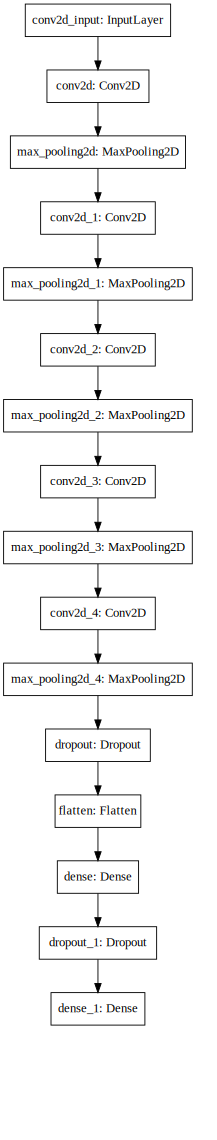

In [16]:
SVG(model_to_dot(model_single, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [17]:
model_single.fit(X_full_train, y_full_train, batch_size=128, epochs=15, verbose=1,validation_data=(X_full_cv, y_full_cv))

Train on 7640 samples, validate on 1146 samples
Epoch 1/15
7640/7640 [==============================] - ETA: 6:13 - loss: 0.7015 - accuracy: 0.44 - ETA: 4:44 - loss: 0.6979 - accuracy: 0.47 - ETA: 4:06 - loss: 0.6952 - accuracy: 0.50 - ETA: 3:45 - loss: 0.6968 - accuracy: 0.50 - ETA: 3:32 - loss: 0.6943 - accuracy: 0.51 - ETA: 3:23 - loss: 0.6934 - accuracy: 0.51 - ETA: 3:15 - loss: 0.6927 - accuracy: 0.52 - ETA: 3:07 - loss: 0.6920 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6908 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6895 - accuracy: 0.53 - ETA: 2:52 - loss: 0.6877 - accuracy: 0.54 - ETA: 2:47 - loss: 0.6865 - accuracy: 0.54 - ETA: 2:42 - loss: 0.6859 - accuracy: 0.54 - ETA: 2:37 - loss: 0.6859 - accuracy: 0.54 - ETA: 2:33 - loss: 0.6842 - accuracy: 0.55 - ETA: 2:29 - loss: 0.6848 - accuracy: 0.55 - ETA: 2:25 - loss: 0.6836 - accuracy: 0.55 - ETA: 2:21 - loss: 0.6814 - accuracy: 0.55 - ETA: 2:17 - loss: 0.6830 - accuracy: 0.55 - ETA: 2:14 - loss: 0.6828 - accuracy: 0.55 - ETA: 2:11 - loss

Epoch 4/15
7640/7640 [==============================] - ETA: 3:17 - loss: 0.2282 - accuracy: 0.92 - ETA: 3:21 - loss: 0.2421 - accuracy: 0.91 - ETA: 3:21 - loss: 0.2522 - accuracy: 0.91 - ETA: 3:11 - loss: 0.2294 - accuracy: 0.92 - ETA: 3:05 - loss: 0.2446 - accuracy: 0.91 - ETA: 3:00 - loss: 0.2444 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2497 - accuracy: 0.90 - ETA: 2:50 - loss: 0.2423 - accuracy: 0.90 - ETA: 2:46 - loss: 0.2419 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:38 - loss: 0.2426 - accuracy: 0.90 - ETA: 2:34 - loss: 0.2409 - accuracy: 0.90 - ETA: 2:30 - loss: 0.2452 - accuracy: 0.90 - ETA: 2:26 - loss: 0.2511 - accuracy: 0.90 - ETA: 2:23 - loss: 0.2486 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2486 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2463 - accuracy: 0.90 - ETA: 2:13 - loss: 0.2466 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2483 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2520 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2489 - accuracy: 0.90 - ETA: 2:01 - loss: 0.

Epoch 7/15
7640/7640 [==============================] - ETA: 2:58 - loss: 0.1279 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1082 - accuracy: 0.97 - ETA: 2:54 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:52 - loss: 0.1300 - accuracy: 0.95 - ETA: 2:49 - loss: 0.1268 - accuracy: 0.95 - ETA: 2:46 - loss: 0.1328 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1355 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1384 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1412 - accuracy: 0.94 - ETA: 2:35 - loss: 0.1335 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1314 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1407 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1354 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1381 - accuracy: 0.95 - ETA: 2:20 - loss: 0.1368 - accuracy: 0.95 - ETA: 2:19 - loss: 0.1370 - accuracy: 0.95 - ETA: 2:18 - loss: 0.1375 - accuracy: 0.95 - ETA: 2:15 - loss: 0.1402 - accuracy: 0.95 - ETA: 2:11 - loss: 0.1439 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1460 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1432 - accuracy: 0.94 - ETA: 2:02 - loss: 0.

Epoch 10/15
7640/7640 [==============================] - ETA: 3:10 - loss: 0.1334 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1344 - accuracy: 0.95 - ETA: 3:00 - loss: 0.1149 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1108 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1072 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1076 - accuracy: 0.96 - ETA: 2:48 - loss: 0.1011 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1071 - accuracy: 0.96 - ETA: 2:41 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0977 - accuracy: 0.96 - ETA: 2:35 - loss: 0.0963 - accuracy: 0.96 - ETA: 2:32 - loss: 0.0942 - accuracy: 0.96 - ETA: 2:29 - loss: 0.0933 - accuracy: 0.96 - ETA: 2:26 - loss: 0.1007 - accuracy: 0.96 - ETA: 2:23 - loss: 0.1012 - accuracy: 0.96 - ETA: 2:19 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0985 - accuracy: 0.96 - ETA: 2:12 - loss: 0.0967 - accuracy: 0.96 - ETA: 2:09 - loss: 0.0967 - accuracy: 0.96 - ETA: 2:06 - loss: 0.0975 - accuracy: 0.96 - ETA: 2:03 - loss: 0.0970 - accuracy: 0.96 - ETA: 1:59 - loss: 0

Epoch 13/15
7640/7640 [==============================] - ETA: 2:58 - loss: 0.0519 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0644 - accuracy: 0.98 - ETA: 2:55 - loss: 0.0662 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0691 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0742 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0758 - accuracy: 0.97 - ETA: 2:45 - loss: 0.0759 - accuracy: 0.96 - ETA: 2:43 - loss: 0.0784 - accuracy: 0.96 - ETA: 2:39 - loss: 0.0748 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0758 - accuracy: 0.96 - ETA: 2:33 - loss: 0.0737 - accuracy: 0.96 - ETA: 2:31 - loss: 0.0712 - accuracy: 0.96 - ETA: 2:31 - loss: 0.0687 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0691 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:23 - loss: 0.0681 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0668 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0650 - accuracy: 0.97 - ETA: 2:15 - loss: 0.0625 - accuracy: 0.97 - ETA: 2:11 - loss: 0.0609 - accuracy: 0.97 - ETA: 2:07 - loss: 0.0612 - accuracy: 0.97 - ETA: 2:03 - loss: 0

In [23]:
test_score, test_acc = model_single.evaluate(X_full_test,y_full_test)

765/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 10s 13ms/sample - loss: 0.0481 - accuracy: 0.9778


In [24]:
print('Test accuracy is:', test_acc)
print('Test score is :', test_score)

Test accuracy is: 0.9777778
Test score is : 0.07607604941608859


In [25]:
#Output the classes (0 or 1) rather than the probabilities for the confusion matrix
yhat_full_test = model_single.predict_classes(X_full_test)
yhat_full_test_pred = model_single.predict(X_full_test) #Get the probabilities in case

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       376
           1       0.96      1.00      0.98       389

    accuracy                           0.98       765
   macro avg       0.98      0.98      0.98       765
weighted avg       0.98      0.98      0.98       765



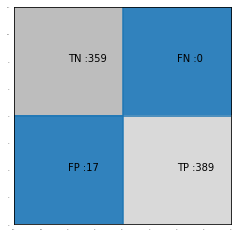

accuracy is : 0.9777777777777777
F1 score is : 0.9786163522012579
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.022222222222222223
Sensitivity / Recall : 1.0
Specificity : 0.9547872340425532
Precision : 0.958128078817734
False positive rate : 0.04521276595744681


In [26]:
generate_confusion_matrix(y_full_test,yhat_full_test)

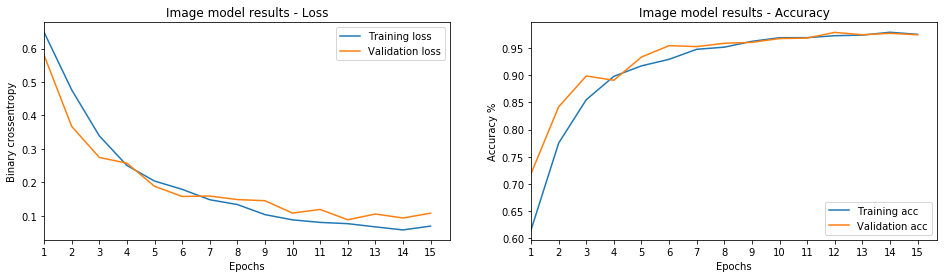

In [42]:
model_graphs(model_single,labels = False)

In [71]:
# C.ravel() #(tn, fp, fn, tp)

array([362,  14,   1, 388], dtype=int64)

## SHAP

SHAP (SHapley Additive exPlanations) (https://github.com/slundberg/shap) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.


In [34]:
background = X_full_train[np.random.choice(X_full_train.shape[0], 100, replace=False)]

# explain predictions of the model on several images
e = shap.GradientExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version
# e = shap.DeepExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version


In [35]:
B = np.block([yhat_full_test,y_full_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([  2,  44,  55, 245, 319, 327, 332, 347, 408, 511, 637, 645, 671,
       681, 695, 715, 728], dtype=int64)

In [36]:
print(yhat_full_test[327:333].ravel())
print(y_full_test[327:333])

[1 1 0 0 1 1]
[0 1 0 0 1 0]


In [37]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_full_test[327:333])

In [38]:
labels = y_full_test[327:333] + yhat_full_test[327:333].ravel()/10
labels

array([0.1, 1.1, 0. , 0. , 1.1, 0.1])

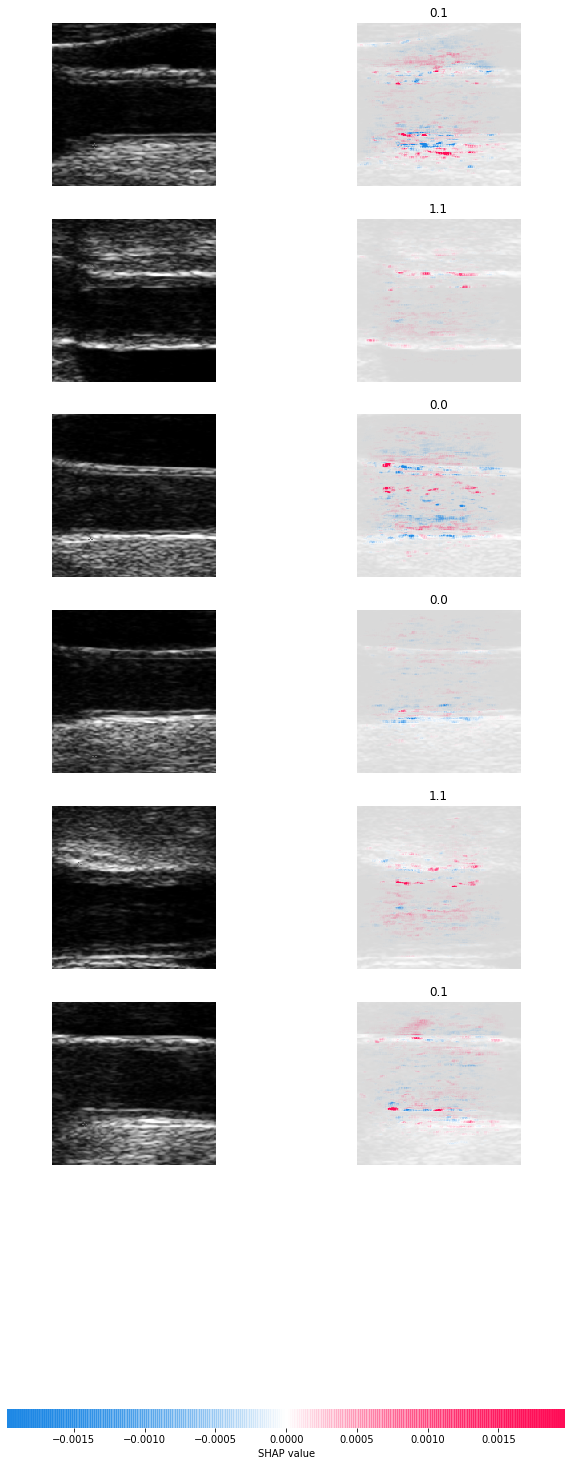

In [40]:
#Correct is first, predicted is second
shap.image_plot(shap_values, X_full_test[327:333],labels = labels[:,np.newaxis],show = False)
fig = plt.gcf()
fig.set_size_inches((10, 30))

### Combined labels and images

#### Create images, or load the existing augmented images in the next section

In [235]:
#Create new images from images with plaque & modify the old ones to be smaller
#Also modify the old labels and create new labels

Full_data_org = []
Full_label_org = []
Full_data_tag = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if '_data_CCA2_'+filename in kv_tag_dict and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
        
        #Apply the cropper to the loaded images
        d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
        Full_data_org.append(d[0].astype('float32'))
        Full_label_org.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
        plt.imsave('./CCA2_2_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                              label = kv_dict.get(filename)),d[0])
        #Save the label images as well, though the class is the same, so no need to add it twice
        Full_data_tag.append(l[0].astype('float32'))
        plt.imsave('./CCA2_2_labels_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])
        counter+=1
    else:
        continue

counter = 0
generate_nb = 16
k = 5 # High number will create memory errors for the arrays, normally >10,000 images
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1}

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1) :
        if '_data_CCA2_'+filename in kv_tag_dict and filename.endswith(".png"): #Cross check that these are in the labels
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True)
            for image,label in zip(d,l):
                Full_data_org.append(image.astype('float32'))
                Full_label_org.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./CCA2_2_augmented/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_data_tag.append(label.astype('float32'))
                plt.imsave('./CCA2_2_labels_augmented/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue

In [32]:
#If data already exists, load from here

Full_data_org = []
Full_label_org = []
Full_data_tag = []

directory_file = 'CCA2_2_augmented'
directory_label = 'CCA2_2_labels_augmented'

for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_org.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_org.append(np.int64(0))
        im = image_load(directory_file, filename, sizeh = 205, sizev = 205)
        Full_data_org.append(im)
    else:
        continue

for filename in tqdm_notebook(os.listdir(directory_label)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        im = image_load(directory_label, filename, sizeh = 205, sizev = 205)
        Full_data_tag.append(im)
    else:
        continue

In [33]:
#Train Test Split
X_train_org, X_org_1, y_train, y_1, X_train_tag, X_tag_1 = train_test_split(
                    np.array(Full_data_org), np.array(Full_label_org), np.array(Full_data_tag), 
                    test_size=0.2, random_state=42, stratify = Full_label_org)

#Train Test Split for validation set
X_cv_org, X_test_org, y_cv, y_test, X_cv_tag, X_test_tag = train_test_split(
                    X_org_1, y_1, X_tag_1,
                    test_size=0.4, random_state=42, stratify = y_1)


In [34]:
X_train_org, X_cv_org, X_test_org = format_set(X_train_org, X_cv_org, X_test_org,img_width = 205,img_height=205)
X_train_tag, X_cv_tag, X_test_tag = format_set(X_train_tag, X_cv_tag, X_test_tag,img_width = 205,img_height=205)

In [35]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org,X_train_tag]

#BatchNormlization layers cause the model to seriously overfit
original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting
main_output = Dense(1, activation='sigmoid')(x)

model_combo = Model(inputs=[original_input, tagged_input], outputs=[main_output])
model_combo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_combo.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 203, 203, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 203, 203, 32) 896         input_2[0][0]                    
______________________________________________________________________________________________

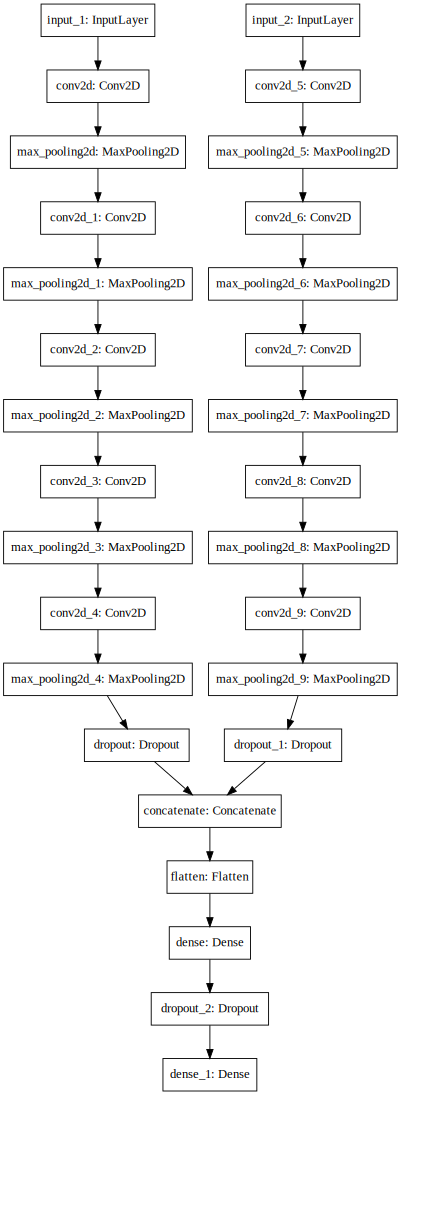

In [36]:
SVG(model_to_dot(model_combo, dpi = 65).create(prog='dot', format='svg'))

In [37]:
model_combo.fit([X_train_org,X_train_tag], y_train, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org,X_cv_tag], y_cv))

Train on 7496 samples, validate on 1125 samples
Epoch 1/15
7496/7496 [==============================] - ETA: 7:59 - loss: 0.6972 - accuracy: 0.46 - ETA: 6:00 - loss: 0.6978 - accuracy: 0.47 - ETA: 5:10 - loss: 0.6969 - accuracy: 0.47 - ETA: 4:44 - loss: 0.6952 - accuracy: 0.48 - ETA: 4:24 - loss: 0.6915 - accuracy: 0.49 - ETA: 4:11 - loss: 0.6908 - accuracy: 0.50 - ETA: 4:00 - loss: 0.6903 - accuracy: 0.50 - ETA: 3:52 - loss: 0.6896 - accuracy: 0.51 - ETA: 3:43 - loss: 0.6880 - accuracy: 0.51 - ETA: 3:35 - loss: 0.6853 - accuracy: 0.52 - ETA: 3:28 - loss: 0.6828 - accuracy: 0.53 - ETA: 3:21 - loss: 0.6792 - accuracy: 0.54 - ETA: 3:15 - loss: 0.6748 - accuracy: 0.55 - ETA: 3:09 - loss: 0.6669 - accuracy: 0.57 - ETA: 3:04 - loss: 0.6625 - accuracy: 0.58 - ETA: 2:59 - loss: 0.6533 - accuracy: 0.59 - ETA: 2:54 - loss: 0.6468 - accuracy: 0.60 - ETA: 2:49 - loss: 0.6398 - accuracy: 0.61 - ETA: 2:47 - loss: 0.6293 - accuracy: 0.62 - ETA: 2:43 - loss: 0.6207 - accuracy: 0.63 - ETA: 2:39 - loss

7496/7496 [==============================] - ETA: 4:03 - loss: 0.0990 - accuracy: 0.97 - ETA: 3:51 - loss: 0.1190 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1164 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1059 - accuracy: 0.96 - ETA: 3:35 - loss: 0.0922 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0966 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0967 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0924 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0847 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0889 - accuracy: 0.97 - ETA: 3:09 - loss: 0.0883 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0874 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0877 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0857 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0826 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0827 - accuracy: 0.97 - ETA: 2:45 - loss: 0.0806 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0807 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0800 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0780 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0791 - accu

7496/7496 [==============================] - ETA: 4:05 - loss: 0.0194 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0179 - accuracy: 0.99 - ETA: 3:59 - loss: 0.0203 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0224 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0271 - accuracy: 0.99 - ETA: 3:36 - loss: 0.0317 - accuracy: 0.99 - ETA: 3:32 - loss: 0.0328 - accuracy: 0.99 - ETA: 3:28 - loss: 0.0327 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0338 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0323 - accuracy: 0.98 - ETA: 3:12 - loss: 0.0353 - accuracy: 0.98 - ETA: 3:09 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:04 - loss: 0.0353 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0351 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:50 - loss: 0.0359 - accuracy: 0.98 - ETA: 2:46 - loss: 0.0367 - accuracy: 0.98 - ETA: 2:42 - loss: 0.0358 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0361 - accuracy: 0.98 - ETA: 2:34 - loss: 0.0347 - accuracy: 0.98 - ETA: 2:30 - loss: 0.0334 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0329 - accu

In [38]:
test_score2, test_acc2 = model_combo.evaluate([X_test_org,X_test_tag],y_test)

750/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 11s 14ms/sample - loss: 0.0341 - accuracy: 0.9827


In [39]:
print('Test accuracy is:', test_acc2)
print('Test score is :', test_score2)

Test accuracy is: 0.9826667
Test score is : 0.06472328235891958


In [40]:
yhat_test_pred = model_combo.predict([X_test_org,X_test_tag]) #predict_classes doesn't work for non sequential, returns % chance
yhat_test = np.around(yhat_test_pred).flatten().astype(int) #Round to 0 or 1 depending on prediction

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       374
           1       0.97      1.00      0.98       376

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



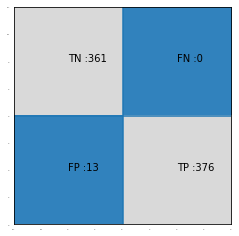

accuracy is : 0.9826666666666667
F1 score is : 0.9830065359477124
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.017333333333333333
Sensitivity / Recall : 1.0
Specificity : 0.9652406417112299
Precision : 0.9665809768637532
False positive rate : 0.034759358288770054


In [41]:
generate_confusion_matrix(y_test,yhat_test)

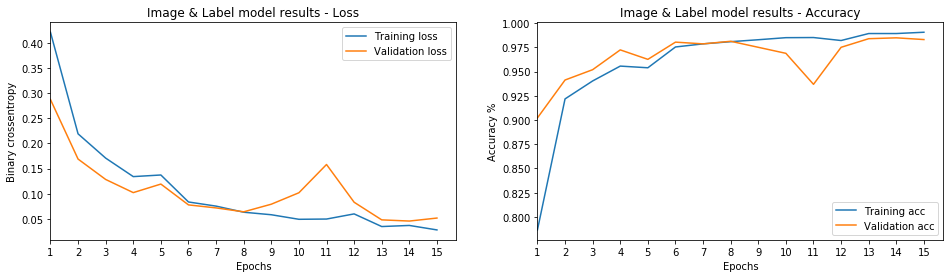

In [42]:
model_graphs(model_combo)

In [43]:
randomizer = np.random.choice(X_train_tag.shape[0], 100, replace=False)
background = [X_train_org[randomizer],X_train_tag[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_combo, background) #Deep Explainer doesn't work yet for tf 2.0

In [44]:
B = np.block([yhat_test[:,np.newaxis],y_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([105, 106, 117, 233, 240, 255, 415, 422, 449, 458, 552, 579, 724],
      dtype=int64)

In [45]:
print(yhat_test[103:109],yhat_test[np.where(np.sum(B,axis=1) == 1 )[0]])
print(y_test[103:109],y_test[np.where(np.sum(B,axis=1) == 1 )[0]])

[0 0 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org[103:109],X_test_tag[103:109]])
labels_org = y_test[103:109] + yhat_test[103:109]/10
labels_org

array([0. , 0. , 0.1, 0.1, 1.1, 1.1])

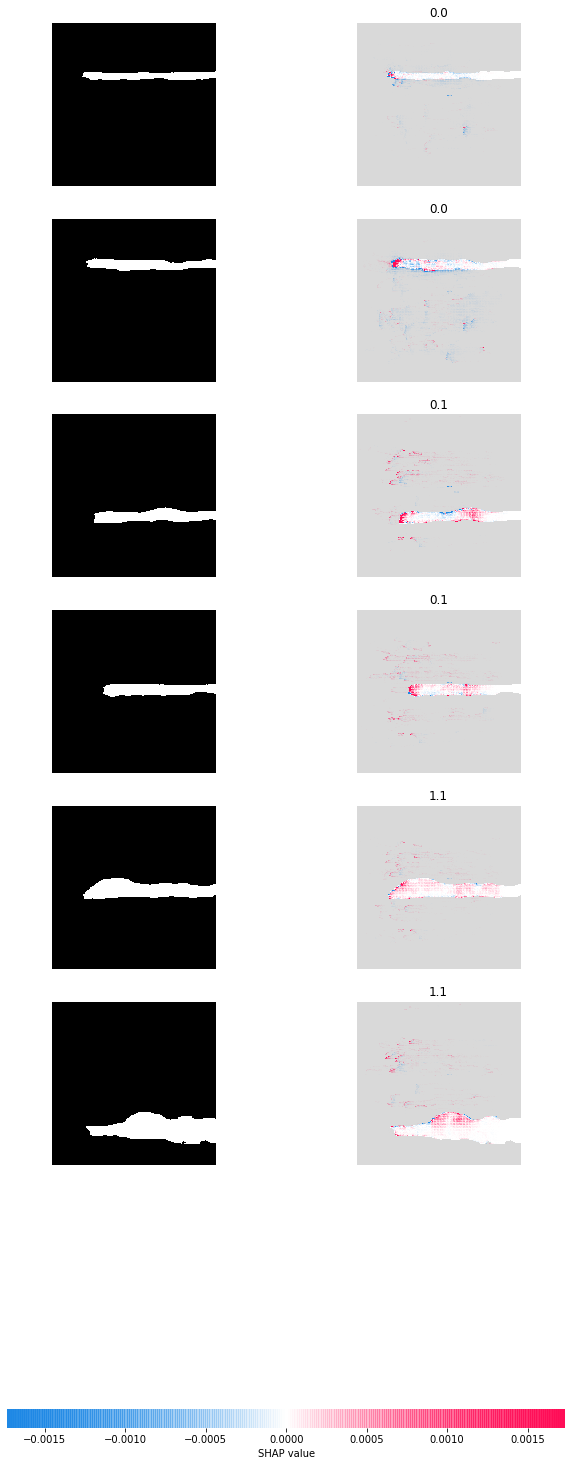

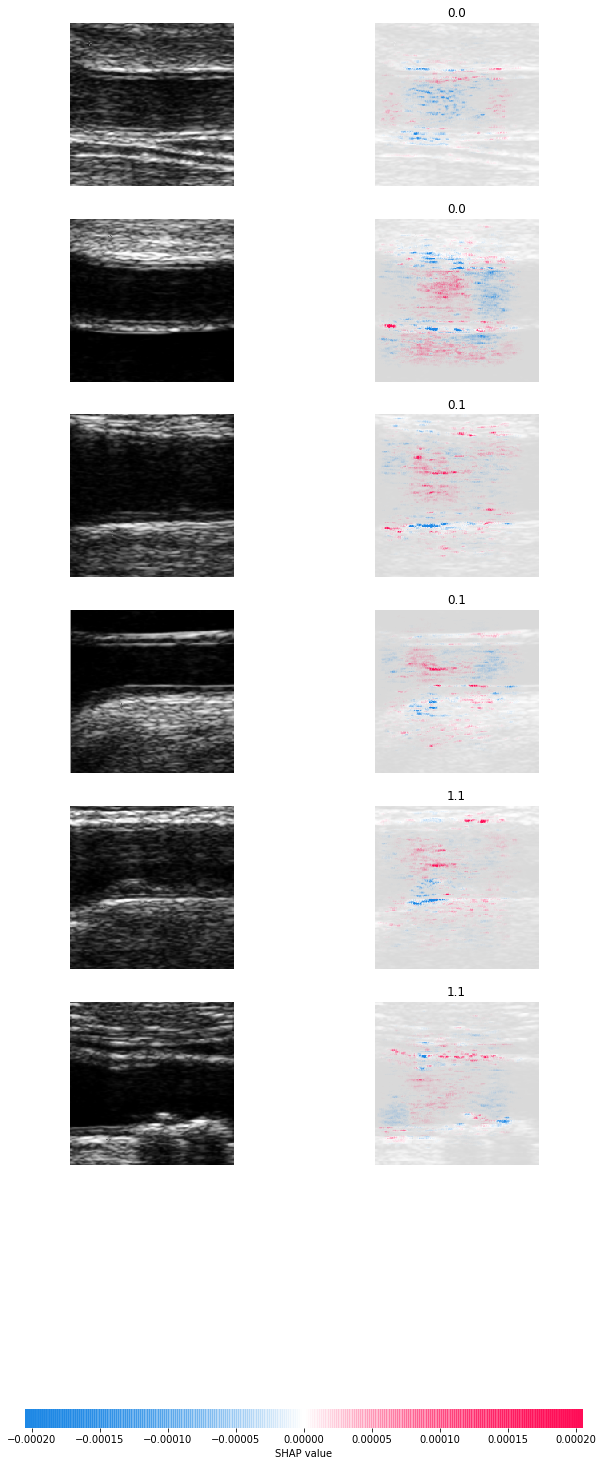

In [47]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag[103:109],labels = labels_org[:,np.newaxis],show=False) #Tag
fig = plt.gcf()
fig.set_size_inches((10, 30),forward = True)

shap.image_plot([shap_values[0][0]], X_test_org[103:109],labels = labels_org[:,np.newaxis],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((10, 30))

### Converting data to greyscale for faster run

#### If exist already, load from code underneath

In [20]:
Full_data_org_grey = []
Full_data_tag_grey = []
Full_label_grey = []

directory_file = 'CCA2_2_augmented'

for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_grey.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_grey.append(np.int64(0))
        im = image_load(directory_file, filename, sizeh = 205, sizev = 205)
        im = grey(im) #IMPORTANT!
        Full_data_org_grey.append(im)
        plt.imsave('./Grey_images_CCA2/Grey_augmented/grey_{filename}.png'.format(filename = filename[:-4]),im) #save the new image
    else:
        continue

directory_label = 'CCA2_2_labels_augmented'

for filename in tqdm_notebook(os.listdir(directory_label)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        im = image_load(directory_label, filename, sizeh = 205, sizev = 205)
        im = grey(im) #IMPORTANT!
        Full_data_tag_grey.append(im)
        plt.imsave('./Grey_images_CCA2/Grey_labels_augmented/grey_{filename}.png'.format(filename = filename[:-4]),im)
    else:
        continue

In [108]:
# if already exists, load from here
Full_data_org_grey = []
Full_data_tag_grey = []
Full_label_grey = []

directory_file = 'Grey_images_CCA2/Grey_augmented'
directory_label = 'Grey_images_CCA2/Grey_labels_augmented'

for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        if filename.endswith("1.png"):
            Full_label_grey.append(np.int64(1)) #Get the 0 or 1 indications
        else:
            Full_label_grey.append(np.int64(0))
        im = image_load(directory_file, filename, sizeh = 205, sizev = 205,grayscale = True)
        Full_data_org_grey.append(im)
    else:
        continue

for filename in tqdm_notebook(os.listdir(directory_label)) :
    if filename.endswith(".png") or filename.endswith(".jpg"):
        im = image_load(directory_label, filename, sizeh = 205, sizev = 205,grayscale = True)
        Full_data_tag_grey.append(im)
    else:
        continue

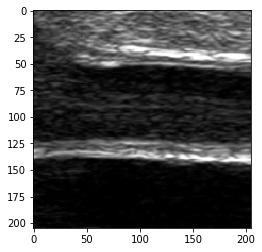

In [10]:
plt.imshow(Full_data_org_grey[0],cmap=plt.get_cmap('gray'))

In [11]:
#Train Test Split
X_train_org_grey, X_org_1_grey, y_train_grey, y_1_grey, X_train_tag_grey, X_tag_1_grey = train_test_split(
                    np.array(Full_data_org_grey), np.array(Full_label_grey), np.array(Full_data_tag_grey), 
                    test_size=0.2, random_state=42, stratify = Full_label_grey)

#Train Test Split for validation set
X_cv_org_grey, X_test_org_grey, y_cv_grey, y_test_grey, X_cv_tag_grey, X_test_tag_grey = train_test_split(
                    X_org_1_grey, y_1_grey, X_tag_1_grey,
                    test_size=0.4, random_state=42, stratify = y_1_grey)


In [19]:
X_train_org_grey, X_cv_org_grey, X_test_org_grey = format_set(X_train_org_grey, X_cv_org_grey, X_test_org_grey,img_width = 205,img_height=205,grayscale = True)
X_train_tag_grey, X_cv_tag_grey, X_test_tag_grey = format_set(X_train_tag_grey, X_cv_tag_grey, X_test_tag_grey,img_width = 205,img_height=205,grayscale = True)

In [30]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org_grey,X_train_tag_grey]

original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting
main_output = Dense(1, activation='sigmoid')(x)

model_grey = Model(inputs=[original_input, tagged_input], outputs=[main_output])
model_grey.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_grey.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 205, 205, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 205, 205, 1) 0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 203, 203, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 203, 203, 16) 160         input_11[0][0]                   
____________________________________________________________________________________________

In [31]:
model_grey.fit([X_train_org_grey,X_train_tag_grey], y_train_grey, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org_grey,X_cv_tag_grey], y_cv_grey))

Train on 7496 samples, validate on 1125 samples
Epoch 1/15
7496/7496 [==============================] - ETA: 5:16 - loss: 0.6902 - accuracy: 0.57 - ETA: 3:42 - loss: 0.6963 - accuracy: 0.50 - ETA: 3:10 - loss: 0.6967 - accuracy: 0.49 - ETA: 2:52 - loss: 0.6952 - accuracy: 0.50 - ETA: 2:40 - loss: 0.6944 - accuracy: 0.50 - ETA: 2:31 - loss: 0.6935 - accuracy: 0.51 - ETA: 2:24 - loss: 0.6929 - accuracy: 0.52 - ETA: 2:17 - loss: 0.6922 - accuracy: 0.53 - ETA: 2:10 - loss: 0.6926 - accuracy: 0.53 - ETA: 2:04 - loss: 0.6927 - accuracy: 0.52 - ETA: 1:59 - loss: 0.6921 - accuracy: 0.53 - ETA: 1:54 - loss: 0.6918 - accuracy: 0.54 - ETA: 1:50 - loss: 0.6914 - accuracy: 0.54 - ETA: 1:46 - loss: 0.6912 - accuracy: 0.54 - ETA: 1:42 - loss: 0.6903 - accuracy: 0.55 - ETA: 1:39 - loss: 0.6895 - accuracy: 0.55 - ETA: 1:35 - loss: 0.6884 - accuracy: 0.55 - ETA: 1:33 - loss: 0.6877 - accuracy: 0.54 - ETA: 1:29 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:27 - loss: 0.6864 - accuracy: 0.55 - ETA: 1:24 - loss

7496/7496 [==============================] - ETA: 1:53 - loss: 0.0601 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0959 - accuracy: 0.97 - ETA: 1:48 - loss: 0.1146 - accuracy: 0.97 - ETA: 1:46 - loss: 0.1221 - accuracy: 0.96 - ETA: 1:44 - loss: 0.1289 - accuracy: 0.96 - ETA: 1:41 - loss: 0.1352 - accuracy: 0.95 - ETA: 1:40 - loss: 0.1332 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1350 - accuracy: 0.95 - ETA: 1:35 - loss: 0.1332 - accuracy: 0.95 - ETA: 1:33 - loss: 0.1395 - accuracy: 0.94 - ETA: 1:32 - loss: 0.1396 - accuracy: 0.94 - ETA: 1:30 - loss: 0.1368 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1303 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1374 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1362 - accuracy: 0.94 - ETA: 1:22 - loss: 0.1370 - accuracy: 0.94 - ETA: 1:20 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1397 - accuracy: 0.94 - ETA: 1:14 - loss: 0.1392 - accuracy: 0.94 - ETA: 1:12 - loss: 0.1408 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1402 - accu

7496/7496 [==============================] - ETA: 1:50 - loss: 0.1005 - accuracy: 0.96 - ETA: 1:48 - loss: 0.0972 - accuracy: 0.96 - ETA: 1:46 - loss: 0.0895 - accuracy: 0.96 - ETA: 1:44 - loss: 0.0804 - accuracy: 0.96 - ETA: 1:42 - loss: 0.0719 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0755 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0755 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0792 - accuracy: 0.97 - ETA: 1:33 - loss: 0.0858 - accuracy: 0.96 - ETA: 1:31 - loss: 0.0841 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0786 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0771 - accuracy: 0.97 - ETA: 1:25 - loss: 0.0760 - accuracy: 0.97 - ETA: 1:23 - loss: 0.0738 - accuracy: 0.97 - ETA: 1:21 - loss: 0.0763 - accuracy: 0.97 - ETA: 1:19 - loss: 0.0767 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0757 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0758 - accuracy: 0.97 - ETA: 1:14 - loss: 0.0745 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0728 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0706 - accu

In [33]:
test_score3, test_acc3 = model_grey.evaluate([X_test_org_grey,X_test_tag_grey],y_test_grey)

750/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 5s 7ms/sample - loss: 0.0474 - accuracy: 0.9747


In [34]:
print('Test accuracy is:', test_acc3)
print('Test score is :', test_score3)

Test accuracy is: 0.97466666
Test score is : 0.06957700909674168


In [ ]:
yhat_test_grey_pred = model_grey.predict([X_test_org_grey,X_test_tag_grey]) #predict_classes doesn't work for non sequential, returns % chance
yhat_test_grey = np.around(yhat_test_grey_pred).flatten().astype(int) #Round to 0 or 1 depending on prediction

generate_confusion_matrix(y_test_grey,yhat_test_grey)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       374
           1       0.95      1.00      0.98       376

    accuracy                           0.97       750
   macro avg       0.98      0.97      0.97       750
weighted avg       0.98      0.97      0.97       750



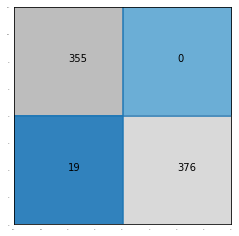

accuracy is : 0.9746666666666667
F1 score is : 0.9753566796368353
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.025333333333333333
Sensitivity / Recall : 1.0
Specificity : 0.9491978609625669
Precision : 0.9518987341772152
False positive rate : 0.05080213903743316


In [39]:
randomizer = np.random.choice(X_train_tag_grey.shape[0], 100, replace=False)
background = [X_train_org_grey[randomizer],X_train_tag_grey[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_grey, background) #Deep Explainer doesn't work yet for tf 2.0
B = np.block([yhat_test_grey[:,np.newaxis],y_test_grey[:,np.newaxis]])
print(np.where(np.sum(B,axis=1) == 1 )[0]) #Get misclassifications

labels_org_grey = y_test_grey[103:109] + yhat_test_grey[103:109]/10
labels_org_grey

[105 106 117 137 233 240 255 275 296 301 322 345 415 422 449 458 552 579
 638]


array([0. , 0. , 0.1, 0.1, 1.1, 1.1])

In [41]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org_grey[103:109],X_test_tag_grey[103:109]])

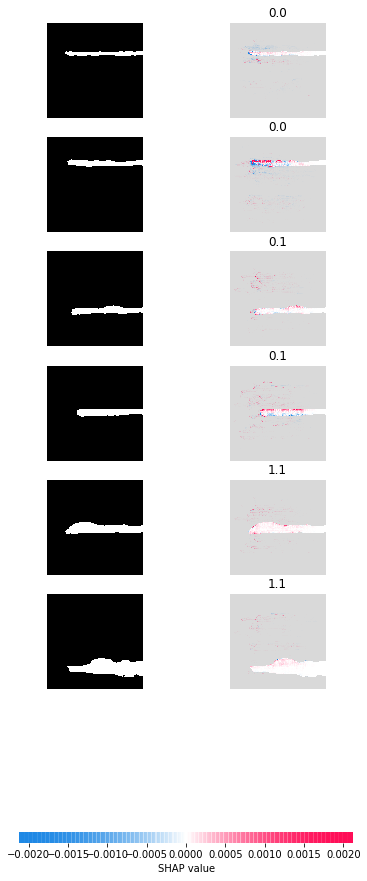

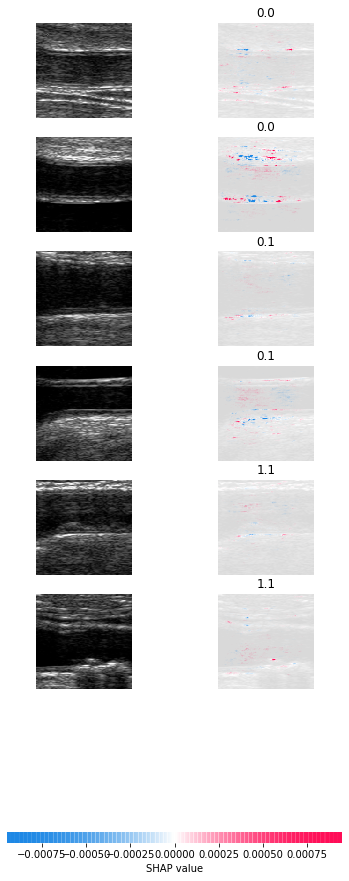

In [44]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag_grey[103:109],labels = labels_org_grey[:,np.newaxis]) #Tag
# shap.image_plot([shap_values[0][i] for i in range(2)], X_test_org[103:109]) #Orginals
shap.image_plot([shap_values[0][0]], X_test_org_grey[103:109],labels = labels_org_grey[:,np.newaxis]) #Orginals

In [59]:
# Find a way to display larger SHAP images and display - done
# extraction of features from the CNN
# Crop all images to avoid bias of the CNN - done
# Check GANS to generate new images with plaque - done
# Usar regresion
# Put tables of accuracy, sensitivity - done

### Test on previous set

In [23]:
# kv_dict_newset
df_newset = pd.read_excel("imt_data_newset.xlsx")
kv_dict_newset= dict(zip(df_newset['File_name'].values,df_newset['Class'].values))
kv_dict_newset

{'100TN.jpg': 0,
 '10FN.jpg': 1,
 '10TEST20.jpg': 0,
 '10TP.jpg': 1,
 '11TEST20.jpg': 0,
 '11TN.jpg': 0,
 '11TP.jpg': 1,
 '12FN.jpg': 1,
 '12FP.jpg': 0,
 '12TEST20.jpg': 0,
 '12TN.jpg': 0,
 '12TP.jpg': 1,
 '13FN.jpg': 1,
 '13FP.jpg': 0,
 '13TEST20.jpg': 0,
 '13TN.jpg': 0,
 '13TP.jpg': 1,
 '14FN.jpg': 1,
 '14FP.jpg': 0,
 '14TEST20.jpg': 0,
 '15FN.jpg': 1,
 '15FP.jpg': 0,
 '16FN.jpg': 1,
 '16FP.jpg': 0,
 '16TEST20.jpg': 0,
 '16TP.jpg': 1,
 '17FN.jpg': 1,
 '17FP.jpg': 0,
 '17TEST20.jpg': 0,
 '17TP.jpg': 1,
 '18FN.jpg': 1,
 '18FP.jpg': 0,
 '18TEST20.jpg': 0,
 '18TN.jpg': 0,
 '18TP.jpg': 1,
 '19TEST20.jpg': 0,
 '19TP.jpg': 1,
 '1FN.jpg': 1,
 '1TEST20.jpg': 0,
 '1TN.jpg': 0,
 '1TP.jpg': 1,
 '20FN.jpg': 1,
 '20FP.jpg': 0,
 '20TEST20.jpg': 0,
 '20TN.jpg': 0,
 '21FN.jpg': 1,
 '21FP.jpg': 0,
 '21TN.jpg': 0,
 '21TP.jpg': 1,
 '22FN.jpg': 1,
 '22FP.jpg': 0,
 '22TN.jpg': 0,
 '22TP.jpg': 1,
 '23FN.jpg': 1,
 '23FP.jpg': 0,
 '23TN.jpg': 0,
 '23TP.jpg': 1,
 '24TN.jpg': 0,
 '24TP.jpg': 1,
 '25FN.jpg': 1,

In [37]:
#Crop and flip the 159 set like the previous ones

Newset_data_org = []
Newset_label_org = []
Newset_data_tag = []

directory_file = 'Set_159/Images_tag2_originals'
directory_label = 'Set_159/Images_tag2'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename in kv_dict_newset and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, filename.split('.')[0]+'_2Lab.png', sizeh = 224, sizev = 224) #Different names for the labeled images
        
        #Apply the cropper to the loaded images
        d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
        Newset_data_org.append(d[0].astype('float32'))
        Newset_label_org.append(kv_dict_newset.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
        plt.imsave('./Set_159/Images_tag2_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                              label = kv_dict_newset.get(filename)),d[0])
        #Save the label images as well, though the class is the same, so no need to add it twice
        Newset_data_tag.append(l[0].astype('float32'))
        plt.imsave('./Set_159/Images_tag2_labels_augmented/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict_newset.get(filename)),l[0])
        counter+=1
    else:
        continue


In [59]:
yhat_newset_org = model_single.predict_classes(np.array(Newset_data_org)).ravel()

In [62]:
test_score_newset, test_acc_newset = model_single.evaluate(np.array(Newset_data_org),np.array(Newset_label_org))
print('Test accuracy is:', test_acc_newset)
print('Test score is :', test_score_newset)

159/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
generate_confusion_matrix(np.array(Newset_label_org),yhat_newset_org)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       108
           1       0.94      1.00      0.97        51

    accuracy                           0.98       159
   macro avg       0.97      0.99      0.98       159
weighted avg       0.98      0.98      0.98       159



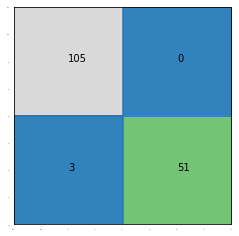

accuracy is : 0.9811320754716981
F1 score is : 0.9714285714285714
Miss rate is : 0.0
NPV is : 1.0


Error rate : 0.018867924528301886
Sensitivity / Recall : 1.0
Specificity : 0.9722222222222222
Precision : 0.9444444444444444
False positive rate : 0.027777777777777776


### Regression test

In [15]:
#We can't apply augmentation as all the IMT values will be the same
#We simply check the existing images and get their IMT values

Regression_org = []
Regression_label = []
Regression_tag = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

#Remember to use kv_dict_imt in this case for the label value
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if '_data_CCA2_'+filename in kv_tag_dict and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
        
        #Load the images directly
        Regression_org.append(im_data.astype('float32'))
        Regression_label.append(kv_dict_imt.get(filename)) #Get the imt indications from the dictionary
        Regression_tag.append(im_label.astype('float32'))
        
        #Apply the cropper to the loaded images
#         d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
#         Regression_org.append(d[0].astype('float32'))
#         Regression_label.append(kv_dict_imt.get(filename)) #Get the imt indications from the dictionary
#         #Save the label images as well, though the class is the same, so no need to add it twice
#         Regression_tag.append(l[0].astype('float32'))
    else:
        continue


In [16]:
#Train Test Split, without stratify since we are going for a regression
X_train_org_reg, X_1_org_reg, y_train_reg, y_1_reg, X_train_tag_reg, X_1_tag_reg = train_test_split(
                    np.array(Regression_org), np.array(Regression_label), np.array(Regression_tag), 
                    test_size=0.2, random_state=42)

#Train Test Split for validation set, without stratify since we are going for a regression
X_cv_org_reg, X_test_org_reg, y_cv_reg, y_test_reg, X_cv_tag_reg, X_test_tag_reg = train_test_split(
                    X_1_org_reg, y_1_reg, X_1_tag_reg,
                    test_size=0.4, random_state=42)

#Check for channels first or last - in this case the sizes are 224,224,3
X_train_org_reg, X_cv_org_reg, X_test_org_reg = format_set(X_train_org_reg, X_cv_org_reg, X_test_org_reg
                                                           ,img_width = 224,img_height=224)
X_train_tag_reg, X_cv_tag_reg, X_test_tag_reg = format_set(X_train_tag_reg, X_cv_tag_reg, X_test_tag_reg
                                                           ,img_width = 224,img_height=224)

In [25]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org_reg,X_train_tag_reg]

original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting

main_output = Dense(1, activation='relu')(x) #Regression, so use a linear or relu activation - given the data is always positive, we can use relu

model_reg = Model(inputs=[original_input,tagged_input], outputs=[main_output])
model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_reg.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 222, 222, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 222, 222, 32) 896         input_12[0][0]                   
____________________________________________________________________________________________

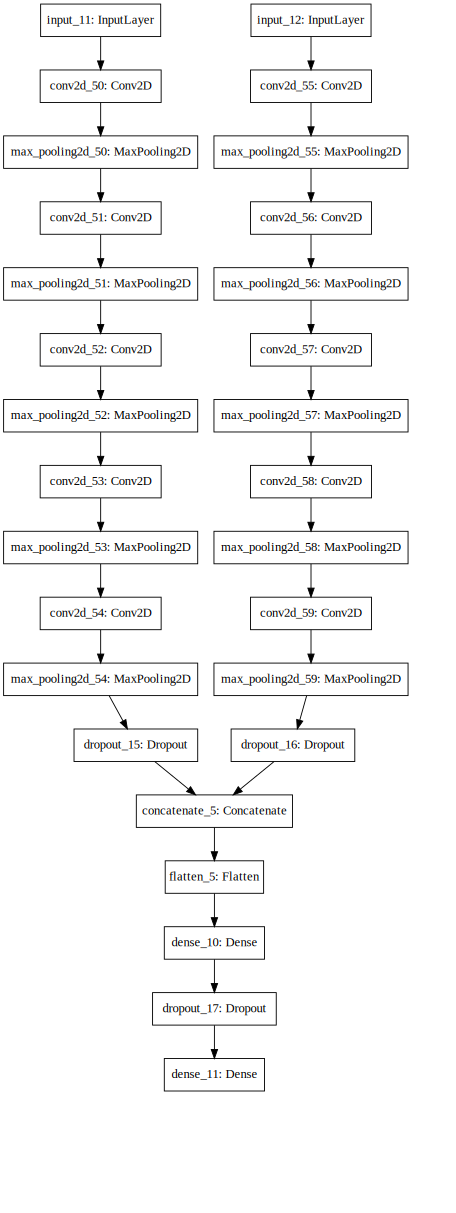

In [26]:
SVG(model_to_dot(model_reg, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [27]:
model_reg.fit([X_train_org_reg,X_train_tag_reg], y_train_reg, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org_reg,X_cv_tag_reg], y_cv_reg))

Train on 3784 samples, validate on 568 samples
Epoch 1/15
3784/3784 [==============================] - ETA: 4:45 - loss: 0.5444 - mae: 0.699 - ETA: 5:24 - loss: 0.3601 - mae: 0.518 - ETA: 4:12 - loss: 0.2649 - mae: 0.421 - ETA: 3:30 - loss: 0.2222 - mae: 0.377 - ETA: 3:04 - loss: 0.1943 - mae: 0.346 - ETA: 2:45 - loss: 0.1757 - mae: 0.327 - ETA: 2:30 - loss: 0.1611 - mae: 0.310 - ETA: 2:18 - loss: 0.1504 - mae: 0.298 - ETA: 2:08 - loss: 0.1417 - mae: 0.288 - ETA: 1:58 - loss: 0.1346 - mae: 0.280 - ETA: 1:52 - loss: 0.1311 - mae: 0.275 - ETA: 1:44 - loss: 0.1311 - mae: 0.271 - ETA: 1:36 - loss: 0.1269 - mae: 0.267 - ETA: 1:29 - loss: 0.1220 - mae: 0.261 - ETA: 1:22 - loss: 0.1184 - mae: 0.257 - ETA: 1:15 - loss: 0.1154 - mae: 0.253 - ETA: 1:09 - loss: 0.1114 - mae: 0.249 - ETA: 1:03 - loss: 0.1086 - mae: 0.245 - ETA: 57s - loss: 0.1059 - mae: 0.241 - ETA: 52s - loss: 0.1026 - mae: 0.23 - ETA: 46s - loss: 0.1000 - mae: 0.23 - ETA: 40s - loss: 0.0978 - mae: 0.23 - ETA: 35s - loss: 0.0960 

3784/3784 [==============================] - ETA: 2:22 - loss: 0.0243 - mae: 0.121 - ETA: 2:16 - loss: 0.0277 - mae: 0.123 - ETA: 2:10 - loss: 0.0255 - mae: 0.121 - ETA: 2:05 - loss: 0.0276 - mae: 0.125 - ETA: 1:59 - loss: 0.0282 - mae: 0.127 - ETA: 1:54 - loss: 0.0266 - mae: 0.123 - ETA: 1:49 - loss: 0.0275 - mae: 0.126 - ETA: 1:44 - loss: 0.0267 - mae: 0.124 - ETA: 1:39 - loss: 0.0264 - mae: 0.124 - ETA: 1:34 - loss: 0.0257 - mae: 0.122 - ETA: 1:29 - loss: 0.0254 - mae: 0.122 - ETA: 1:24 - loss: 0.0251 - mae: 0.121 - ETA: 1:20 - loss: 0.0258 - mae: 0.121 - ETA: 1:15 - loss: 0.0256 - mae: 0.121 - ETA: 1:10 - loss: 0.0256 - mae: 0.121 - ETA: 1:05 - loss: 0.0254 - mae: 0.120 - ETA: 1:00 - loss: 0.0262 - mae: 0.121 - ETA: 56s - loss: 0.0264 - mae: 0.121 - ETA: 51s - loss: 0.0268 - mae: 0.12 - ETA: 46s - loss: 0.0267 - mae: 0.12 - ETA: 41s - loss: 0.0266 - mae: 0.12 - ETA: 37s - loss: 0.0267 - mae: 0.12 - ETA: 32s - loss: 0.0268 - mae: 0.12 - ETA: 27s - loss: 0.0269 - mae: 0.12 - ETA: 22s

In [28]:
test_score_reg, test_acc_reg = model_reg.evaluate([X_test_org_reg,X_test_tag_reg],y_test_reg)

379/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 7s 18ms/sample - loss: 0.0170 - mae: 0.0971


In [29]:
print('Test mae is:', test_acc_reg)
print('Test score is :', test_score_reg)

Test mae is: 0.09712798
Test score is : 0.024581427302575207


In [30]:
yhat_test_reg = model_reg.predict([X_test_org_reg,X_test_tag_reg]) #predict_classes doesn't work for non sequential, returns % chance

In [31]:
np.block([yhat_test_reg,y_test_reg[:,np.newaxis]])

array([[1.25151575, 1.015     ],
       [0.85725528, 1.073     ],
       [0.78570914, 0.729     ],
       [0.85202622, 0.918     ],
       [1.18343914, 1.39      ],
       [0.78606933, 0.823     ],
       [1.14582384, 1.058     ],
       [0.64436257, 0.648     ],
       [0.83230835, 0.965     ],
       [0.6841563 , 0.726     ],
       [0.66512501, 0.733     ],
       [0.89490223, 1.119     ],
       [1.20646381, 1.053     ],
       [0.68310595, 0.635     ],
       [0.7024644 , 0.885     ],
       [0.86658412, 1.05      ],
       [1.14040077, 1.111     ],
       [0.7179417 , 0.802     ],
       [0.90803802, 1.03      ],
       [0.82846695, 0.745     ],
       [0.91454709, 0.919     ],
       [0.68395674, 0.899     ],
       [0.82702553, 0.88      ],
       [0.6193006 , 0.656     ],
       [0.78741634, 0.809     ],
       [1.03246665, 1.209     ],
       [0.89630961, 0.924     ],
       [0.98808473, 1.054     ],
       [0.81814152, 0.701     ],
       [0.84723294, 0.892     ],
       [0.

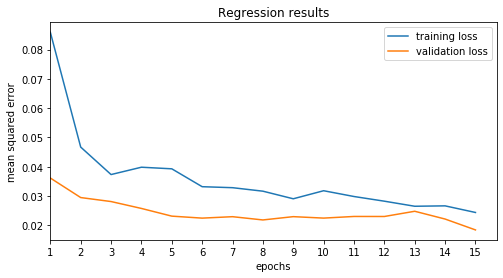

In [33]:
model_graphs(model_reg,regression=True)

In [43]:
randomizer = np.random.choice(X_train_tag_reg.shape[0], 100, replace=False)
background = [X_train_org_reg[randomizer],X_train_tag_reg[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_reg, background) #Deep Explainer doesn't work yet for tf 2.0

In [53]:
print(yhat_test_reg[103:109].flatten())
print(y_test_reg[103:109])

[0.727191   0.8472963  0.56906563 0.8976581  0.64854336 0.7913288 ]
[1.067 0.82  0.471 0.892 0.655 0.806]


In [ ]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org_reg[103:109],X_test_tag_reg[103:109]])

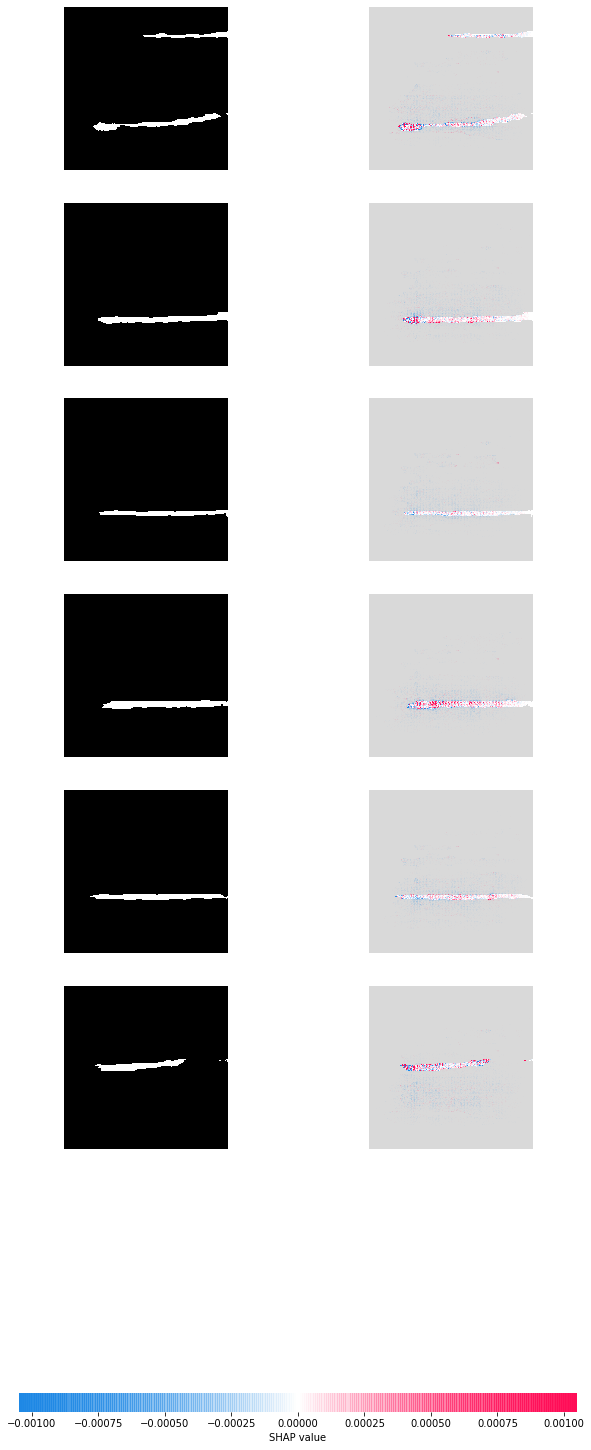

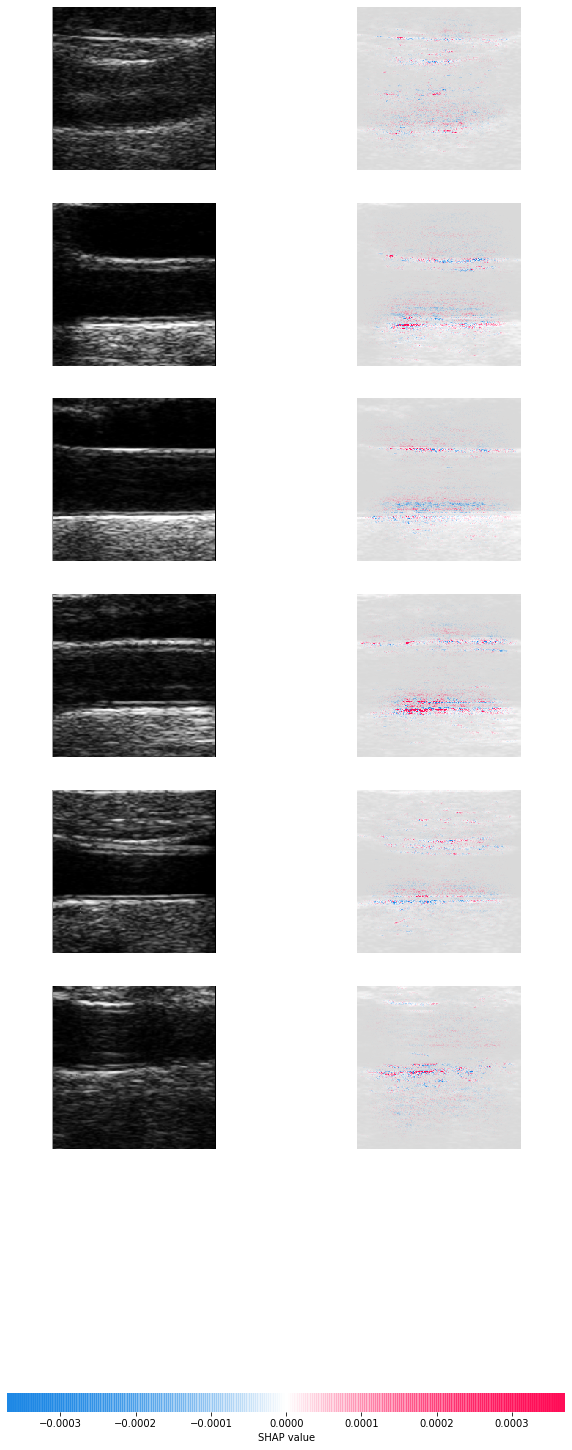

In [42]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag_reg[103:109],show=False) #Tag
fig = plt.gcf()
fig.set_size_inches((10, 30),forward = True)
# shap.image_plot([shap_values[0][i] for i in range(2)], X_test_org[103:109]) #Orginals
shap.image_plot([shap_values[0][0]], X_test_org_reg[103:109],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((10, 30))